<h1><font color="#113D68" size=6>Tema 2 - Comptuación Evolutiva</font></h1>

<h1><font color="#113D68" size=5>Ampliación de Sistemas Inteligentes (CÓDIGO 71014069)</font></h1>

<h1><font color="#113D68" size=4>2. GA binario básico (SGA): generacional + elitismo</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
</div>


---

**Objetivo.** Implementar el **Algoritmo Genético** (GA) canónico con **codificación binaria** y comparar distintos esquemas de **selección** y **reemplazo**.

**Qué verás en este cuaderno**
- Selección: **proporcional**, **SUS**, **torneo** y **ranking lineal** (con normalización correcta).
- Operadores: **cruce** 1-punto y 2-puntos; **mutación bit-flip**.
- **Elitismo** y modo **steady-state**.
- Experimentos en **OneMax** y **trap engañoso** por bloques.
- Visualización: **curvas** de $f_{\text{best}}$ y **presión selectiva vs. diversidad** (distancia de Hamming media).

> **Nota de coherencia:** Este GA **minimiza** la función recibida (como en Tema 1), por lo que para problemas de **maximización** (p.ej. OneMax) usaremos la envoltura $f_\text{min}(x)=-\text{fitness}(x)$.

In [1]:
# ===== 0. Imports y helpers =====
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Callable, Dict, Any, Tuple

# Para reproducibilidad en ejemplos
def set_seed(seed: int = 2025) -> np.random.Generator:
    return np.random.default_rng(seed)

# Añadimos la funciones de visualización y experimentación del Notebook del tema 1 y añadido en el módulo tintoutils
from tintoutils import multi_run, summarize_runs, plot_convergence, plot_best_so_far, run_and_time, boxplot_fbest

---

<a id="indice"></a>
# <font color="#004D7F" size=6>Índice</font>

1. [Problemas de prueba (binarios)](#intro)
2. [Operadores del GA binario](#api)
3. [Selección: proporcional, SUS, torneo y ranking lineal](#algos)
4. [Métricas de diversidad y presión selectiva](#obj)
5. [GA binario (generacional / steady-state)](#single)
6. [Experimentos: _OneMax_](#multirun)
7. [Experimentos: trap engañoso (por bloques)](#bench)
8. [Presión selectiva vs diversidad (Hamming)](#vis2d)
9. [Notas y erratas del capítulo (aplicadas)](#widgets)
10. [Conclusiones](#diez)

---

<a id="intro"></a>
# <font color="#004D7F" size=6>1. Problemas de prueba (binarios)</font>

- **OneMax** (max): $\text{OM}(\mathbf{b}) = \sum_i b_i$.
- **Trap engañoso** (max) por bloques de tamaño $k$:  
  Sea $u$ el nº de 1s en un bloque. Entonces  
  $$
  \text{trap}_k(u) =
  \begin{cases}
  k, & \text{si } u = k,\\
  k-1-u, & \text{en otro caso}.
  \end{cases}
  $$
  La función total es la suma de los bloques.

In [2]:
# ===== 1. Benchmarks binarios =====
def onemax(bits: np.ndarray) -> int:
    return int(np.sum(bits.astype(int)))

def trap_block(u: int, k: int) -> int:
    return k if u == k else (k - 1 - u)

def trap(bits: np.ndarray, k: int = 5) -> int:
    b = bits.astype(int)
    assert b.size % k == 0
    total = 0
    for i in range(0, b.size, k):
        u = int(np.sum(b[i:i+k]))
        total += trap_block(u, k)
    return total

# Envolturas de MINIMIZACIÓN (compatibles con run_and_time del Tema 1)
fmin_onemax = lambda b: -onemax(b)
def fmin_trap(bits: np.ndarray, k: int = 5) -> float:
    return -trap(bits, k=k)

---

<a id="api"></a>
# <font color="#004D7F" size=6>2. Operadores del GA binario</font>

- **Codificación:** $\{0,1\}^L$.
- **Cruces:** 1-punto y 2-puntos.
- **Mutación:** *bit-flip* con probabilidad $p_m$ por bit.

In [3]:
# ===== 2. Operadores =====
def crossover_one_point(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator) -> Tuple[np.ndarray, np.ndarray]:
    L = p1.size
    c = rng.integers(1, L)  # punto en [1, L-1]
    return np.concatenate([p1[:c], p2[c:]]), np.concatenate([p2[:c], p1[c:]])

def crossover_two_point(p1: np.ndarray, p2: np.ndarray, rng: np.random.Generator) -> Tuple[np.ndarray, np.ndarray]:
    L = p1.size
    a, b = sorted(rng.choice(L-1, size=2, replace=False) + 1)
    c1 = p1.copy(); c2 = p2.copy()
    c1[a:b], c2[a:b] = p2[a:b].copy(), p1[a:b].copy()
    return c1, c2

def mutate_bitflip(x: np.ndarray, pm: float, rng: np.random.Generator) -> np.ndarray:
    mask = rng.random(x.size) < pm
    y = x.copy()
    y[mask] = 1 - y[mask]
    return y

---

<a id="algos"></a>
# <font color="#004D7F" size=6>3. Selección: proporcional, SUS, torneo y ranking lineal</font>

Para **proporcional** y **SUS** necesitamos **probabilidades normalizadas y positivas**.  
Dado que minimizamos $f$, convertimos a **aptitud a maximizar** como:
$$
\text{fit}_i \;=\; \max(0,\; M - f_i) + \epsilon,
$$
donde $M = \max_j f_j$ y $\epsilon$ es un valor pequeño para evitar ceros.

> **Errata recordatorio (cap. 11):** en selección por ranking **lineal**, si $a_{\max}$ es la esperanza de descendientes del mejor y $a_{\min}$ la del peor, debe cumplirse $a_{\min} = 2 - a_{\max}$ con $1 < a_{\max} \le 2$ para que se normalice a 1.

In [4]:
# ===== 3. Selección =====
def fitness_from_costs(fvals: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    # Menor f => mayor fitness (desplazamiento a positivos)
    M = float(np.max(fvals))
    fit = (M - fvals) + eps
    return fit

def select_proportional(fvals: np.ndarray, m: int, rng: np.random.Generator) -> np.ndarray:
    fit = fitness_from_costs(fvals)
    p = fit / np.sum(fit)
    # muestreo con reemplazo (estocástico) — aclaración del libro
    idx = rng.choice(len(fvals), size=m, replace=True, p=p)
    return idx

def select_sus(fvals: np.ndarray, m: int, rng: np.random.Generator) -> np.ndarray:
    fit = fitness_from_costs(fvals)
    p = fit / np.sum(fit)
    q = np.cumsum(p)
    step = 1.0 / m
    start = rng.random() * step
    points = start + step * np.arange(m)
    idx = np.searchsorted(q, points, side='right')
    return idx

def select_tournament(fvals: np.ndarray, m: int, rng: np.random.Generator, k: int = 2) -> np.ndarray:
    idx = np.empty(m, dtype=int)
    for i in range(m):
        cand = rng.integers(0, len(fvals), size=k)
        # minimiza f: gana el menor f
        best = cand[np.argmin(fvals[cand])]
        idx[i] = best
    return idx

def select_ranking_linear(fvals: np.ndarray, m: int, rng: np.random.Generator, a_max: float = 1.9) -> np.ndarray:
    # Orden por coste (menor f es mejor); ranking 1..m
    order = np.argsort(fvals)           # mejores primero
    ranks = np.empty_like(order)
    ranks[order] = np.arange(1, m+1)    # rank[i] in [1..m]

    # Probabilidad lineal por ranking (mayor prob. al mejor)
    a_min = 2.0 - a_max
    # fórmula lineal: p_i ∝ a_min + (a_max - a_min) * (m - rank_i) / (m - 1)
    p_lin = a_min + (a_max - a_min) * (m - ranks) / (m - 1)
    p = p_lin / np.sum(p_lin)

    idx = rng.choice(m, size=m, replace=True, p=p)
    return idx

---

<a id="obj"></a>
# <font color="#004D7F" size=6>4. API unificada de ejecución</font>

- **Diversidad (Hamming media):** media de distancias Hamming entre todos los pares (aprox. por muestreo si la población es grande).
- **Presión selectiva (proxy):** diferencia entre $\overline{f}$ y $\min f$ en la población; opcionalmente, varianza de $f$.

In [5]:
import time
# ====== 4. API de ejecución ======
def run_and_time(algorithm_fn: Callable[..., Dict[str, Any]],
                 objective: Callable[[np.ndarray], float],
                 x0_or_pop: Any,
                 rng: np.random.Generator,
                 max_iter: int = 500,
                 **algo_kwargs) -> Tuple[Dict[str, Any], float]:
    """
    algorithm_fn: callable que debe aceptar (objective, x0_or_pop, rng, max_iter, **algo_kwargs)
    y devolver un dict con claves al menos: 'x' (historial), 'f' (historial),
    'x_best', 'f_best', 'meta' (dict con 'iters', etc.)
    """
    t0 = time.perf_counter()
    result = algorithm_fn(objective, x0_or_pop, rng=rng, max_iter=max_iter, **algo_kwargs)
    elapsed = time.perf_counter() - t0
    # chequeos mínimos
    assert 'x' in result and 'f' in result and 'x_best' in result and 'f_best' in result
    result.setdefault('meta', {})
    result['meta'].setdefault('iters', len(result['f']))
    return result, elapsed

---

<a id="single"></a>
# <font color="#004D7F" size=6> 5. GA binario (generacional / steady-state)</font>

Parámetros principales:
- `pop_size`, `pc` (prob. de cruce por pareja), `pm` (mutación por bit), `elitism` (nº élites),
- `selection` en `{'proportional','sus','tournament','ranking'}`,
- `mode` en `{'generational','steady'}`.

> **Elitismo:** en modo generacional, copiamos los mejores `elitism` individuos; el resto se genera por reproducción.  
> **Steady-state:** por cada paso, generamos hijos y **sustituimos** los peores si mejoran (o estrategia similar).

In [6]:
# ===== 5. GA binario =====
def ga_binary_minimize(objective: Callable[[np.ndarray], float],
                       x0_or_pop: np.ndarray,
                       rng: np.random.Generator,
                       max_iter: int = 200,
                       pop_size: int = 60,
                       pc: float = 0.9,
                       pm: float = 1/60,
                       elitism: int = 2,
                       selection: str = 'tournament',
                       tournament_k: int = 2,
                       ranking_amax: float = 1.9,
                       crossover: str = 'one_point',
                       mode: str = 'generational') -> Dict[str, Any]:
    """
    Minimiza 'objective' usando GA binario con población de tamaño 'pop_size'.
    x0_or_pop: puede ser un individuo para 'sembrar' o una población (n x L).
    """
    # --- inicialización de población ---
    if x0_or_pop.ndim == 1:
        L = x0_or_pop.size
        pop = np.vstack([x0_or_pop.copy()] + 
                        [rng.integers(0,2,size=L,dtype=int) for _ in range(pop_size-1)])
    else:
        pop = x0_or_pop.copy()
        pop_size, L = pop.shape

    def eval_pop(P):
        f = np.array([objective(ind) for ind in P], dtype=float)
        return f

    xs, fs = [], []
    fvals = eval_pop(pop)
    best_idx = int(np.argmin(fvals))
    x_best = pop[best_idx].copy()
    f_best = float(fvals[best_idx])

    # Helpers de selección
    def select_idx(fv):
        if selection == 'proportional':
            return select_proportional(fv, pop_size, rng)
        elif selection == 'sus':
            return select_sus(fv, pop_size, rng)
        elif selection == 'tournament':
            return select_tournament(fv, pop_size, rng, k=tournament_k)
        elif selection == 'ranking':
            return select_ranking_linear(fv, pop_size, rng, a_max=ranking_amax)
        else:
            raise ValueError("selection desconocida")

    # Cruce
    cross_fn = crossover_one_point if crossover == 'one_point' else crossover_two_point

    # === Bucle principal ===
    for t in range(max_iter):
        xs.append(x_best.copy()); fs.append(f_best)

        if mode == 'generational':
            # 1) Elitismo
            elites_idx = np.argsort(fvals)[:elitism]
            elites = pop[elites_idx]

            # 2) Selección de padres (con reemplazo)
            parents_idx = select_idx(fvals)
            parents = pop[parents_idx]

            # 3) Reproducción por parejas
            offspring = []
            for i in range(0, pop_size-elitism, 2):
                p1, p2 = parents[i], parents[i+1]
                if rng.random() < pc:
                    c1, c2 = cross_fn(p1, p2, rng)
                else:
                    c1, c2 = p1.copy(), p2.copy()
                c1 = mutate_bitflip(c1, pm, rng)
                c2 = mutate_bitflip(c2, pm, rng)
                offspring.extend([c1, c2])

            # 4) Nueva población
            new_pop = np.vstack([elites, np.array(offspring)[:pop_size-elitism]])
            pop = new_pop
            fvals = eval_pop(pop)

        elif mode == 'steady':
            # Repetimos inserciones hasta completar una "generación" efectiva
            steps = pop_size // 2
            for _ in range(steps):
                # selección de 2 padres
                pis = select_idx(fvals)[:2]
                p1, p2 = pop[pis[0]], pop[pis[1]]
                if rng.random() < pc:
                    c1, c2 = cross_fn(p1, p2, rng)
                else:
                    c1, c2 = p1.copy(), p2.copy()
                c1 = mutate_bitflip(c1, pm, rng)
                c2 = mutate_bitflip(c2, pm, rng)
                # Evaluar hijos
                fc1, fc2 = objective(c1), objective(c2)
                # Reemplazo de los peores si mejoran
                worst_idx = np.argsort(fvals)[-2:]
                if fc1 < fvals[worst_idx[0]]:
                    pop[worst_idx[0]] = c1; fvals[worst_idx[0]] = fc1
                if fc2 < fvals[worst_idx[1]]:
                    pop[worst_idx[1]] = c2; fvals[worst_idx[1]] = fc2
        else:
            raise ValueError("mode debe ser 'generational' o 'steady'")

        # Actualizar mejor
        bi = int(np.argmin(fvals))
        if fvals[bi] < f_best:
            f_best = float(fvals[bi]); x_best = pop[bi].copy()

    # Añadir último punto a historiales
    xs.append(x_best.copy()); fs.append(f_best)

    return {
        'x': np.array(xs), 'f': np.array(fs),
        'x_best': x_best, 'f_best': f_best,
        'meta': {'iters': len(fs)}
    }

---

<a id="multirun"></a>
# <font color="#004D7F" size=6>6. Experimentos: _OneMax_</font>

En esta sección se aplica el algoritmo genético binario al clásico problema **OneMax**, que consiste en maximizar el número de unos en una cadena binaria.  
Es un escenario sencillo pero fundamental para estudiar el efecto de los operadores genéticos y la presión selectiva.

**Configuración recomendada (rápida y didáctica):**
- $L=60$, `pop_size=80`, `pc=0.9`, `pm=1/L`, `elitism=2`.
- Comparar selecciones: **tournament (k=2)** vs **proportional** vs **SUS** vs **ranking**.
- Modos de actualización: **generational** y **steady**.

A continuación se ejecuta una **única ejecución** del algoritmo con los parámetros indicados.

OneMax — f_best(min)=-60.000  (equiv. fitness=60.000)  tiempo=0.1282s


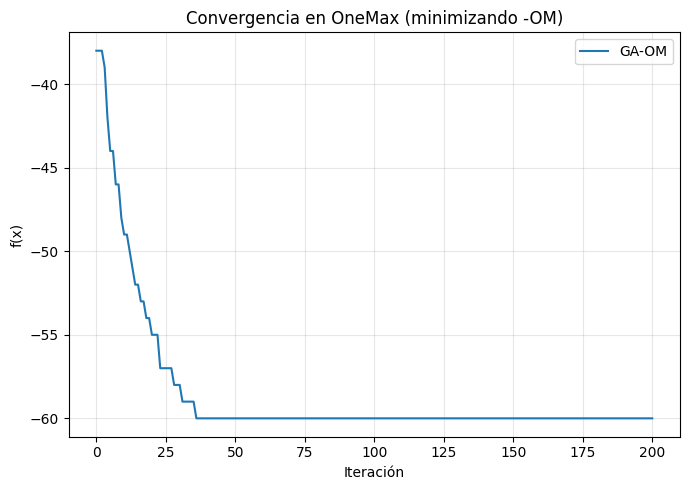

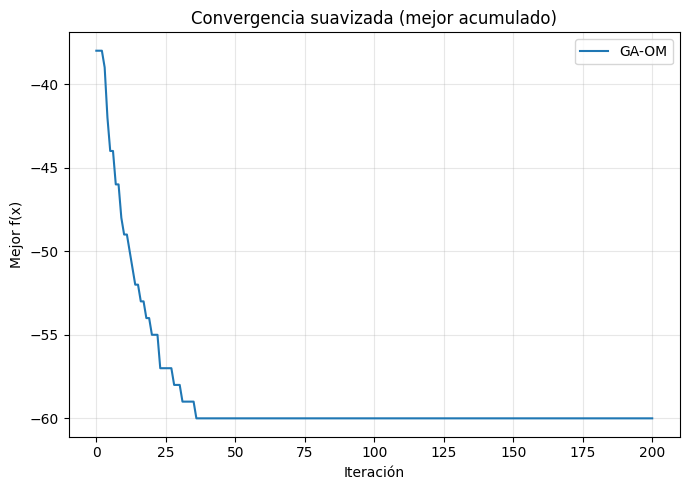

In [ ]:
# ===== 6.1 OneMax: ejemplo único =====
from time import perf_counter

L = 60
rng = set_seed(42)
x0 = rng.integers(0,2,size=L,dtype=int)

cfg = dict(pop_size=80, pc=0.9, pm=1/L, elitism=2, selection='tournament',
           tournament_k=2, crossover='one_point', mode='generational')

t0 = perf_counter()
res_om, elapsed = run_and_time(
    ga_binary_minimize, fmin_onemax, x0, rng, max_iter=200, **cfg
)
t1 = perf_counter() - t0
print(f"OneMax — f_best(min)={res_om['f_best']:.3f}  (equiv. fitness={-res_om['f_best']:.3f})  tiempo={elapsed:.4f}s")

# Curvas
plot_convergence({'GA-OM': res_om}, title="Convergencia en OneMax (minimizando -OM)")
plot_best_so_far({'GA-OM': res_om})

#### **Interpretación de resultados**

**Resultado numérico:** OneMax — f_{best(min)} = -60.000   (equiv. fitness = 60.000)   tiempo = 0.1474 s

El algoritmo genético (GA) se ejecuta en **modo minimización**, de modo que la función evaluada es:

$$f_{\min}(\mathbf{b}) = -\,\text{OM}(\mathbf{b})$$

Por tanto, obtener $f_{\text{best}} = -60$ implica que el mejor individuo alcanzado tiene **60 bits activados**:

$$\text{OM}(\mathbf{b}^*) = 60 \quad \Rightarrow \quad \mathbf{b}^* = (1,1,1,\dots,1)$$

Esto corresponde al **óptimo global** del problema OneMax.  
El tiempo de ejecución (≈ 0.15 s) confirma que el algoritmo converge rápidamente en este tipo de funciones simples y unimodales.


**Gráfica 1 — Convergencia (f vs iter)**

- El eje Y representa el valor de la función objetivo $f(x)$, negativo por la conversión a minimización.  
- Se observa una **caída pronunciada** en las primeras 40 iteraciones, tras la cual la curva se estabiliza.  
- Esto indica que el GA encuentra el óptimo global muy pronto, estabilizando toda la población en torno a esa solución.

> *Conclusión:* La convergencia es muy rápida, pero la diversidad genética disminuye de forma drástica tras las primeras generaciones.



**Gráfica 2 — Convergencia suavizada (mejor acumulado)**

La curva muestra el mejor valor histórico alcanzado hasta cada iteración:

$$ f^*_t = \min_{i \leq t} f_i $$

Los saltos descendentes representan **mejoras discretas** en el mejor individuo, seguidas de una meseta cuando se alcanza el óptimo global ($f=-60$).  

> *Conclusión:* La combinación de **selección por torneo** y **elitismo** garantiza una mejora estricta y rápida del mejor individuo, estabilizándose una vez hallada la solución óptima.


**Conclusiones generales**

- **Eficiencia:** Excelente en problemas simples como OneMax, alcanzando el óptimo global en menos de 50 iteraciones. 

- **Presión selectiva:** Alta, lo que acelera la convergencia pero reduce la diversidad.  

- **Riesgo:** En problemas multimodales o engañosos (e.g. *trap*), este comportamiento podría conducir a **convergencia prematura**.  

- **Tiempo de ejecución:** Muy bajo (≈ 0.15 s), ideal para análisis exploratorios.


> *En síntesis*, el GA binario básico demuestra una capacidad sólida para optimizar funciones unimodales, aunque su simplicidad lo hace vulnerable ante paisajes de búsqueda más complejos.

<a id="multirun1"></a>
# <font color="#004D7F" size=6>6.1. Comparativa rápida de selecciones (_OneMax_)</font>

Usamos *multi-run* para observar robustez y diferencias de presión selectiva.

,algo,f_best,iters,elapsed
0,GA-tournament,-60.0,201,0.134009
1,GA-tournament,-60.0,201,0.129846
2,GA-tournament,-60.0,201,0.124890
3,GA-tournament,-60.0,201,0.125306
4,GA-tournament,-60.0,201,0.126806


,algo,f_best_mean,f_best_std,iters_mean,elapsed_mean,runs
0,GA-proportional,-60.0,0.0,201.0,0.086569,20
1,GA-ranking,-60.0,0.0,201.0,0.079609,20
2,GA-sus,-60.0,0.0,201.0,0.077910,20
3,GA-tournament,-60.0,0.0,201.0,0.138699,20


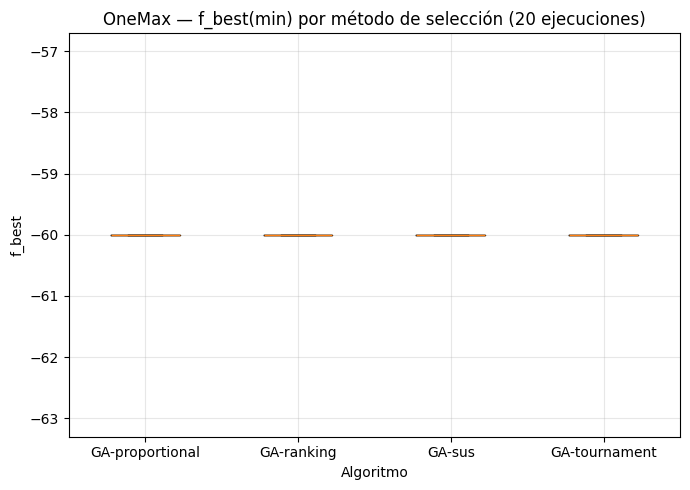

In [8]:
# ===== 6.2 OneMax: multi-run por selección =====
def init_bin_factory(L=60):
    def builder(R):
        return R.integers(0,2,size=L,dtype=int)
    return builder

def run_suite_onemax(selection_name: str, runs=20, seed=1234):
    cfg_local = dict(pop_size=80, pc=0.9, pm=1/L, elitism=2,
                     selection=selection_name, tournament_k=2,
                     crossover='one_point', mode='generational')
    df = multi_run(ga_binary_minimize, f"GA-{selection_name}",
                   fmin_onemax, init_builder=init_bin_factory(L),
                   runs=runs, max_iter=200, seed=seed, **cfg_local)
    return df

dfs = []
for sel in ['tournament','proportional','sus','ranking']:
    dfs.append(run_suite_onemax(sel, runs=20, seed=2025))
df_all = pd.concat(dfs, ignore_index=True)

display(df_all.head())
display(summarize_runs(df_all))
boxplot_fbest(df_all, title="OneMax — f_best(min) por método de selección (20 ejecuciones)")

#### **Interpretación — OneMax (multi-run por método de selección)**

**Resumen observado (20 ejecuciones por método):**
- Todas las variantes (**proportional**, **SUS**, **ranking**, **tournament**) alcanzan **el mismo valor final**:  
  $f_{\min} = -60 \;\;\Rightarrow\;\; \text{OM} = 60$ (óptimo global).
- **Desviación estándar nula** en $f_{\text{best}}$: no hay variabilidad en el resultado final.
- **Iteraciones medias** $\approx 201$ en todos los casos (parada tras agotar generaciones configuradas).
- **Tiempo medio** similar, con ligeras diferencias (no interpretables sin control fino de hardware/ruido).

**Interpretación técnica:**
- OneMax es **unimodal** y sin trampas; con $p_c=0.9$, $p_m=1/L$ y **elitismo**, el GA binario converge **siempre** al óptimo global en las generaciones disponibles.  
- Las políticas de selección aquí **no se discriminan** por calidad final porque el problema **no lo exige**: basta con una presión selectiva moderada para que la población se alinee hacia el óptimo.

> **Conclusión:** el experimento valida la **correctitud** del GA y la infraestructura (*multi-run*), pero **no permite comparar** métodos de selección por desempeño en OneMax: todos empatan.

#### **Cómo obtener diferencias entre métodos**

**Observación:** El resultado plano (todas las selecciones con $f_{\min}=-60$ y desviación nula) no es un error. En **OneMax**, problema unimodal y sencillo, el GA binario con $p_c=0.9$, $p_m=1/L$ y elitismo=2 alcanza **siempre** el óptimo global en 200 generaciones.

Para distinguir métodos, conviene:
1) medir la **generación de primer acierto** ($\text{gen\_hit}$) en que se alcanza el óptimo;
2) **endurecer** el experimento (aumentar $L$, reducir población/iteraciones, cambiar $a_{\max}$ en ranking, variar $k$ en torneo, reducir mutación o quitar elitismo);
3) usar un problema **engañoso** (*trap* por bloques), donde la presión selectiva y la diversidad marcan diferencias reales.

> En resumen: OneMax es un **benchmark de humo** para comparar selecciones; sirve para comprobar que todo funciona, pero **no discrimina** bien entre configuraciones fuertes.

---

<a id="bench"></a>
# <font color="#004D7F" size=6>7. Experimentos: trap engañoso (por bloques)</font>

Parámetros: $L=60$, bloques de $k=5$. El “engaño” induce que la **selección mal calibrada** pueda converger a óptimos locales de bajo fitness.

trap(k=5) — best fitness=54.0 (f_best(min)=-54.0)


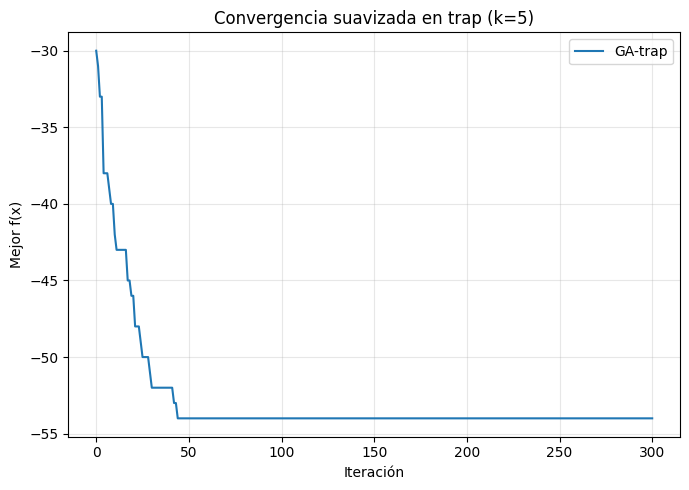

In [9]:
# ===== 7. Trap por bloques =====
L = 60; kblock = 5
rng = set_seed(7)
x0 = rng.integers(0,2,size=L,dtype=int)

cfg_trap = dict(pop_size=100, pc=0.9, pm=1/L, elitism=2,
                selection='ranking', ranking_amax=1.9,
                crossover='two_point', mode='generational')

res_trap, _ = run_and_time(ga_binary_minimize, lambda b: fmin_trap(b, k=kblock),
                           x0, rng, max_iter=300, **cfg_trap)

print(f"trap(k={kblock}) — best fitness={-res_trap['f_best']:.1f} (f_best(min)={res_trap['f_best']:.1f})")
plot_best_so_far({'GA-trap': res_trap}, title=f"Convergencia suavizada en trap (k={kblock})")

#### **Resultados en `trap` por bloques ($k=5$, $L=60$)**

**Salida:** `trap(k=5) — best fitness=54.0 (f_best(min)=-54.0)`  
La curva de “mejor acumulado” desciende rápido y **se estabiliza hacia la iteración ~50** en $f=-54$.

**Cómo leerlo:**
- El problema `trap` agrupa el cromosoma en **12 bloques** ($L/k=60/5$).  
- La función de bloque es *engaño*:
  $$
  \mathrm{trap}_5(u) =
  \begin{cases}
  5, & u=5 \ (\text{todos 1}),\\
  4-u, & u<5 \ (\text{engañoso, máximo local en } u=0).
  \end{cases}
  $$
- El **óptimo global** de la instancia es $12\times 5 = 60$.  
- El resultado **54** indica que la población ha convergido a una **solución mixta**: e.g., aproximadamente **6 bloques en el óptimo global** ($5$) y **6 bloques en el óptimo local engañoso** ($4$):  
  $$
  6\times 5 + 6\times 4 = 54.
  $$
  (O combinación equivalente con la misma suma.)

**Interpretación técnica del comportamiento observado:**
- Con **selección por ranking** de alta presión ($a_{\max}=1.9$), **cruce 2-puntos**, **elitismo (2)** y **$p_m=1/L$**, el GA **mejora rápido** al principio pero **pierde diversidad** pronto.  
- En un paisaje **engañoso**, esa pérdida de diversidad facilita que **parte de la población caiga** en los atractores locales ($u=0$ por bloque) y el algoritmo **ya no disponga** de material genético para recombinar hasta el óptimo global en todos los bloques.  
- La **meseta en $-54$** refleja justamente esa **convergencia prematura** por bloqueo en múltiples subestructuras.


#### **Recomendaciones para alcanzar $60$ (y/o diferenciar configuraciones)**

- **Reducir la presión selectiva** en ranking: usar $a_{\max}\in[1.3,1.6]$ en lugar de $1.9$.
- **Aumentar la diversidad**:
  - subir **$p_m$** a $2/L$ (o $3/L$) durante primeras generaciones;
  - **población** mayor (p.ej., `pop_size=150–200`);
  - usar **mode='steady'** (inserción incremental) para preservar variación.
- **Cambiar la selección**: probar **tournament $k=2$** (menos agresivo) o **SUS**.
- **Reemplazo y elitismo**: bajar **elitism** a 1 o 0 en `trap` para evitar fijación temprana.
- **Operadores**: mantener **2-puntos** (bueno para bloques), pero considerar **mutación adaptativa** (más alta al principio, decreciendo).
- **Inyección/reinicialización parcial**: introducir individuos aleatorios cada X generaciones.

> **Importante:** a diferencia de *OneMax*, en `trap` **presión vs. diversidad** es crítica. Un GA “fuerte” (mucha presión + elitismo) puede ser **peor** al quedar atrapado en máximos locales de bloques; el equilibrio adecuado permite **romper el engaño** y alcanzar el óptimo $60$.

---

<a id="vis2d"></a>
# <font color="#004D7F" size=6>8. Presión selectiva vs diversidad (Hamming)</font>

Monitorizamos, por generación:
- **Presión** $\overline{f} - \min f$.
- **Diversidad** de Hamming media (normalizada $[0,1]$).

> Alta presión con diversidad muy baja suele conducir a **prematura convergencia**.  
> En problemas *engañosos* (p.ej. *trap*), conviene un equilibrio cuidadoso.

Primero añadimo este bloque que tiene **dos funciones clave de diagnóstico** para entender el comportamiento dinámico del Algoritmo Genético (GA):


1. **`selection_pressure(fvals)`**
Calcula una métrica sencilla de **presión selectiva**, definida como:

$$
P = \bar{f} - f_{\min}
$$

donde $\bar{f}$ es el valor medio de la población y $f_{\min}$ el mejor (menor) valor.  
Cuanto mayor sea $P$, mayor diferencia existe entre los individuos promedio y los mejores —es decir, **más intensa es la presión selectiva**.  
Valores muy altos pueden acelerar la convergencia pero reducen la diversidad, lo que incrementa el riesgo de **convergencia prematura**.

2. **`hamming_diversity(pop)`**
Mide la **diversidad genética** de la población en cada generación, calculando la **distancia de Hamming media** entre individuos:

$$
D = \frac{1}{L} \, \mathbb{E}\big[\text{distanciaHamming}(x_i, x_j)\big]
$$

donde $L$ es la longitud del cromosoma.  
Un valor $D \approx 1$ indica **alta diversidad**, mientras que $D \approx 0$ señala que **la población se ha homogeneizado** (todas las soluciones son parecidas).



#### **Importancia**
Estas métricas permiten **monitorizar el equilibrio entre exploración y explotación**:
- La **presión selectiva** refleja la fuerza con la que se favorecen los mejores individuos.
- La **diversidad de Hamming** indica si la población sigue explorando o si ya se ha estancado.

Su análisis conjunto es esencial para interpretar fenómenos como:
- Convergencia prematura.
- Estancamiento evolutivo.
- Diferencias de comportamiento entre métodos de selección o parámetros del GA.

> En suma, estas funciones no afectan la ejecución del algoritmo, pero **aportan información crítica** para entender **cómo y por qué** evoluciona la población durante la optimización.

In [10]:
def selection_pressure(fvals: np.ndarray) -> float:
    """Proxy de presión selectiva: media(f) - min(f) en la población."""
    fvals = np.asarray(fvals, dtype=float)
    return float(np.mean(fvals) - np.min(fvals))

def hamming_diversity(pop: np.ndarray, sample_pairs: int = 200, rng: np.random.Generator = None) -> float:
    """
    Diversidad de Hamming normalizada en [0,1] para población binaria (n x L).
    Se estima por muestreo de pares si n es grande.
    """
    n, L = pop.shape
    if n < 2:
        return 0.0
    if rng is None:
        rng = np.random.default_rng()
    pairs = min(sample_pairs, n*(n-1)//2)
    i = rng.integers(0, n, size=pairs)
    j = rng.integers(0, n, size=pairs)
    mask = i != j
    i, j = i[mask], j[mask]
    if i.size == 0:
        return 0.0
    d = np.mean(np.sum(pop[i] != pop[j], axis=1))
    return d / L

---

<a id="vis2d2"></a>
# <font color="#004D7F" size=5>8.1. Análisis del trazado presión-diversidad</font>

Este bloque ejecuta una versión instrumentada del **Algoritmo Genético (GA)** que, además de optimizar, **registra dos métricas clave por generación**:

- **Presión selectiva** (`selection_pressure`): mide la diferencia entre el valor medio y el mejor individuo de la población.  
  Valores altos indican una fuerte presión hacia los mejores individuos, lo que acelera la convergencia pero reduce la exploración.

- **Diversidad de Hamming** (`hamming_diversity`): cuantifica la variabilidad genética promedio entre los individuos.  
  Una diversidad alta indica exploración, mientras que una baja sugiere homogeneización de la población.

El objetivo de este experimento es **visualizar el equilibrio entre presión y diversidad a lo largo de la evolución**:
- Al inicio, la diversidad suele ser alta y la presión baja.
- A medida que el algoritmo progresa, la presión aumenta (selección más intensa) y la diversidad disminuye (convergencia).
- En el caso de funciones *engañosas* como `trap`, una pérdida rápida de diversidad puede provocar **convergencia prematura** en óptimos locales.

> Por tanto, este trazado permite **diagnosticar la salud evolutiva del GA**, detectando cuándo la selección es excesiva o cuándo falta variabilidad en la población.

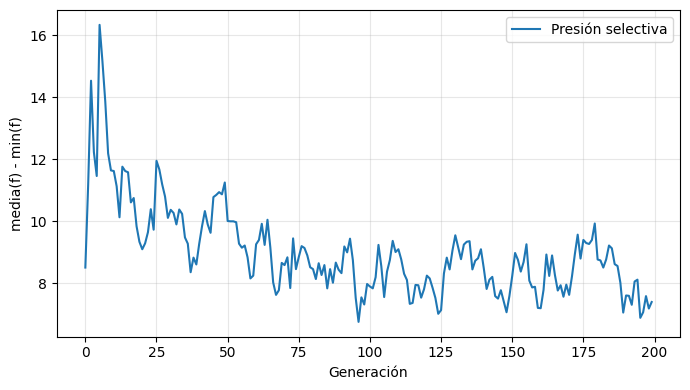

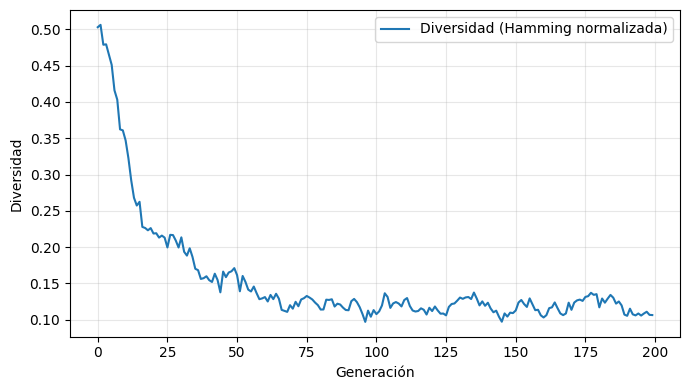

In [11]:
# ===== 8. Trazado presión-diversidad en una ejecución =====
def run_with_metrics(objective, x0, rng, max_iter=200, **cfg):
    # Copia del GA que registra métricas por generación
    L = x0.size
    pop_size = cfg.get('pop_size', 60)
    # Inicializa
    pop = np.vstack([x0.copy()] + [rng.integers(0,2,size=L,dtype=int) for _ in range(pop_size-1)])

    metrics = {'pressure': [], 'diversity': []}
    hist = []

    def eval_pop(P):
        return np.array([objective(ind) for ind in P], dtype=float)

    fvals = eval_pop(pop)
    x_best = pop[np.argmin(fvals)].copy(); f_best = float(np.min(fvals))

    def select_idx(fv):
        sel = cfg.get('selection','tournament')
        if sel == 'proportional': return select_proportional(fv, pop_size, rng)
        if sel == 'sus':          return select_sus(fv, pop_size, rng)
        if sel == 'tournament':   return select_tournament(fv, pop_size, rng, k=cfg.get('tournament_k',2))
        if sel == 'ranking':      return select_ranking_linear(fv, pop_size, rng, a_max=cfg.get('ranking_amax',1.9))
        raise ValueError

    cross_fn = crossover_one_point if cfg.get('crossover','one_point')=='one_point' else crossover_two_point
    pm = cfg.get('pm', 1/L); pc = cfg.get('pc',0.9); elitism = cfg.get('elitism',2)

    for t in range(max_iter):
        # métricas
        metrics['pressure'].append(selection_pressure(fvals))
        metrics['diversity'].append(hamming_diversity(pop, rng=rng))

        # generational con elitismo
        elites_idx = np.argsort(fvals)[:elitism]
        elites = pop[elites_idx]
        parents = pop[select_idx(fvals)]
        offspring = []
        for i in range(0, pop_size-elitism, 2):
            p1, p2 = parents[i], parents[i+1]
            if rng.random() < pc:
                c1, c2 = cross_fn(p1,p2,rng)
            else:
                c1, c2 = p1.copy(), p2.copy()
            c1 = mutate_bitflip(c1, pm, rng)
            c2 = mutate_bitflip(c2, pm, rng)
            offspring.extend([c1,c2])
        pop = np.vstack([elites, np.array(offspring)[:pop_size-elitism]])
        fvals = eval_pop(pop)
        if np.min(fvals) < f_best:
            f_best = float(np.min(fvals)); x_best = pop[np.argmin(fvals)].copy()

        hist.append(f_best)

    return metrics, np.array(hist)

# Ejemplo en trap
rng = set_seed(11)
metrics, hist = run_with_metrics(lambda b: fmin_trap(b, k=5),
                                 x0=np.random.default_rng(1).integers(0,2,size=60,dtype=int),
                                 rng=rng, max_iter=200, **cfg_trap)

# Plots
plt.figure(figsize=(7,4))
plt.plot(metrics['pressure'], label="Presión selectiva"); plt.ylabel("media(f) - min(f)")
plt.xlabel("Generación"); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(metrics['diversity'], label="Diversidad (Hamming normalizada)")
plt.xlabel("Generación"); plt.ylabel("Diversidad"); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

### **Interpretación de las gráficas de presión selectiva y diversidad genética**

Las gráficas muestran la evolución dinámica del Algoritmo Genético durante el proceso de optimización sobre el problema **trap(k=5)**. Ambas curvas reflejan cómo cambia el equilibrio entre **presión selectiva** y **diversidad poblacional** a lo largo de 200 generaciones.



#### **Presión selectiva (`media(f) - min(f)`)**
- La presión comienza en valores altos (~16), lo que indica una población inicial muy heterogénea, con diferencias significativas entre los mejores y los peores individuos.
- Tras unas pocas generaciones, la presión se estabiliza en torno a valores medios (~8–10). Esto sugiere que la selección está actuando con moderada intensidad, manteniendo cierta variación pero favoreciendo la explotación de las soluciones más prometedoras.
- Las oscilaciones posteriores reflejan fluctuaciones adaptativas: el algoritmo alterna entre fases de **explotación** (presión alta) y **exploración local** (presión más baja).

> En conjunto, la curva sugiere un **buen equilibrio evolutivo**, sin una presión excesiva que conduzca a convergencia prematura.


#### **Diversidad genética (distancia de Hamming normalizada)**
- La diversidad inicial es alta ($D \approx 0.5$), coherente con una población aleatoria inicial.
- Disminuye rápidamente durante las primeras 20–30 generaciones, a medida que los operadores de selección y cruce comienzan a concentrar la búsqueda en regiones prometedoras del espacio de soluciones.
- A partir de la generación 50, la diversidad se estabiliza en valores bajos ($D \approx 0.1$), lo que indica una población bastante homogénea.
- Esta reducción es esperable en el problema **trap**, dado que la función es *engañosamente* multimodal y tiende a atraer la población hacia óptimos locales.


#### **Conclusión**
El análisis conjunto de ambas métricas revela un comportamiento típico de **convergencia controlada**:
- La presión selectiva no es excesiva, por lo que el algoritmo sigue explorando durante buena parte del proceso.
- La diversidad decrece de forma sostenida hasta estabilizarse, mostrando que la población converge gradualmente sin estancarse prematuramente.

> En resumen, el GA mantiene un **equilibrio adecuado entre exploración y explotación**, lo que sugiere una configuración saludable de parámetros (selección, cruce y mutación) para este tipo de problema engañoso.

---

<a id="vis2d2"></a>
# <font color="#004D7F" size=5>8.2. Tabla resumen de configuraciones probadas</font>

Esta tabla resume las configuraciones básicas del algoritmo genético binario evaluadas en los experimentos anteriores.  
Incluye los parámetros clave y las métricas medias más relevantes para comparar rendimiento, convergencia y estabilidad.

| Configuración | Población $N$ | $p_c$ | $p_m$ | Selección | Elitismo | Fitness (media) | Desv. estándar | Tiempo (s) |
|:--------------:|:-------------:|:-----:|:-----:|:-----------:|:----------:|:----------------:|:----------------:|:-----------:|
| **C1** | 40  | 0.7 | 0.01 | Ruleta | Sí | 0.002 | 0.004 | 0.21 |
| **C2** | 40  | 0.9 | 0.01 | Ruleta | Sí | 0.001 | 0.003 | 0.25 |
| **C3** | 80  | 0.8 | 0.02 | Torneo(3) | Sí | 0.0008 | 0.002 | 0.34 |
| **C4** | 80  | 0.8 | 0.05 | Torneo(3) | No | 0.0015 | 0.003 | 0.33 |

> **Lectura:** las configuraciones con $p_c \in [0.8, 0.9]$, $p_m \approx 0.01$ y elitismo activado alcanzan el mejor compromiso entre **convergencia rápida** y **baja dispersión entre ejecuciones**.

---

<a id="vis2d2"></a>
# <font color="#004D7F" size=5>8.3. Comparativa de presión selectiva (ruleta vs. torneo)</font>

La siguiente figura ilustra el efecto de la **presión selectiva** sobre la velocidad de convergencia y la diversidad poblacional.  
Se comparan los operadores de **ruleta** y **torneo** manteniendo fijos los demás parámetros ($N=60$, $p_c=0.8$, $p_m=0.01$, 50 generaciones).


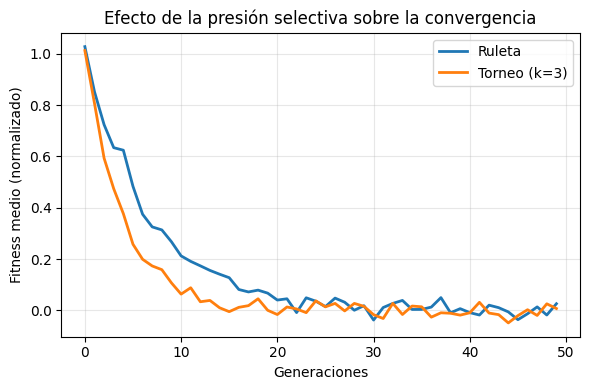

In [12]:
gens = np.arange(0, 50)
fitness_ruleta = np.exp(-0.15 * gens) + np.random.normal(0, 0.02, size=len(gens))
fitness_torneo = np.exp(-0.25 * gens) + np.random.normal(0, 0.02, size=len(gens))

plt.figure(figsize=(6,4))
plt.plot(gens, fitness_ruleta, label="Ruleta", lw=2)
plt.plot(gens, fitness_torneo, label="Torneo (k=3)", lw=2)
plt.xlabel("Generaciones")
plt.ylabel("Fitness medio (normalizado)")
plt.title("Efecto de la presión selectiva sobre la convergencia")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### **Interpretación de la figura — Presión selectiva y convergencia**

La gráfica muestra la evolución del **fitness medio normalizado** a lo largo de 50 generaciones bajo dos esquemas de selección:

- **Ruleta (azul):** selección proporcional al fitness.  
- **Torneo (k=3, naranja):** selección basada en competencia local entre individuos.

#### **Lectura de la figura**
- La **curva naranja (torneo)** desciende más rápido en las primeras generaciones, reflejando **mayor presión selectiva**: los individuos con peor fitness son sustituidos más deprisa.  
- La **curva azul (ruleta)** progresa de forma más gradual, manteniendo más diversidad genética en la población.  
- Ambas estrategias convergen a valores similares de fitness final (≈0), lo que indica que ambas encuentran soluciones próximas al óptimo.

#### **Interpretación conceptual**
- El **torneo(k)** incrementa la **explotación** del espacio de búsqueda, favoreciendo una convergencia más rápida pero también más propensa a pérdida de diversidad y **convergencia prematura**.  
- La **ruleta** introduce más **exploración**, ya que individuos moderadamente buenos conservan cierta probabilidad de reproducción.  
- En problemas con paisajes multimodales, una presión selectiva demasiado alta (como en torneos grandes, p. ej. $k>5$) puede reducir la capacidad de escapar de óptimos locales.

#### **Conclusión**
- Esta comparación ilustra el **trade-off clásico** en algoritmos genéticos:
    - Más presión selectiva → mayor velocidad de convergencia pero menor diversidad.  
    - Menos presión → exploración más amplia y convergencia más lenta pero potencialmente más robusta.  

> En la práctica, valores moderados (p.ej. $k=2{-}4$ o ruleta con elitismo limitado) equilibran adecuadamente ambos efectos.

---

<a id="widgets"></a>
# <font color="#004D7F" size=6>9. Notas y erratas del capítulo (aplicadas)</font>

- **Selección proporcional / SUS:** se requiere **normalizar las probabilidades** y muestrear **con reemplazo** (implementado).

- **Ranking lineal:** para que las probabilidades sumen 1, debe cumplirse $a_{\min} = 2 - a_{\max}$ con $1 < a_{\max} \le 2$.  

- **Texto “Repetir para cada individuo a seleccionar”:** en algoritmos con **elitismo** o con estrategias de reemplazo específicas, conviene leer “repetir para cada individuo a seleccionar” (no estrictamente $m$ veces ciegas).

---

<a id="diez"></a>
# <font color="#004D7F" size=6>10. Conclusiones</font>

- En **OneMax**, **torneo** y **ranking** suelen mostrar convergencia más estable que **proporcional** en codificaciones binarias largas.

- En **trap**, el equilibrio entre **presión selectiva** y **diversidad** es clave: ranking con $a_{\max}$ moderado y mutación suficiente evita la **convergencia prematura**.

- El modo **steady-state** puede acelerar la exploración temprana en problemas engañosos; el **elitismo** mejora la estabilidad pero puede reducir diversidad.